# Voice Recognition with Deep Learning

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np 

# For preprocessing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Plotting data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import os
from pathlib import Path
# set current working dir
os.chdir(Path('/home/adriel_martins/Documents/voice_recognition'))

## Reading Data

Our initial data comes from the numpy array that we made with the 'Signal_Feature_Extraction' notebook.

In [2]:
# The next code loads the saved numpy array of our extracted features
# The first 5 components are features, and the last one is the label.
features_label = np.load(Path('Data/features_label.npy'), allow_pickle=True)
features_label[0]

(array([-3.6667053e+02,  1.1917808e+02, -1.1537009e+01,  3.7124893e+01,
         4.5089059e+00,  1.2463992e+00, -1.6520576e+01, -1.9386774e+01,
        -1.1613708e+01, -7.7634439e+00, -2.3502064e+00, -6.0884881e+00,
         5.2901429e-01, -4.4644852e+00,  5.4440641e+00,  1.7343061e+00,
        -5.1755018e+00, -2.5856745e+00, -6.8001833e+00, -1.0892000e+00,
        -7.3762760e+00, -8.1930122e+00, -2.6990726e+00, -3.3281727e+00,
        -3.3485827e+00, -1.0064723e+00,  2.1757193e-01, -3.9501967e+00,
        -1.3473492e+00, -7.9314518e-01, -4.0448556e+00, -4.8921371e+00,
        -2.9967959e+00, -1.5930473e+00, -1.2883358e+00, -9.3357992e-01,
        -4.6056266e+00, -1.8098402e+00, -1.5934964e+00, -1.9052585e+00],
       dtype=float32),
 array([0.72523016, 0.6711473 , 0.59517676, 0.52301925, 0.5067012 ,
        0.5643972 , 0.60795456, 0.618594  , 0.62857383, 0.6287439 ,
        0.6406759 , 0.6774414 ], dtype=float32),
 array([9.15813434e-04, 5.32634184e-03, 9.42190289e-02, 4.34629083e-01,

In [3]:
# Creating our numpy arrays
features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))
labels = []
for i in range(0, len(features_label)):
    labels.append(np.array(features_label[i][5]))
                
X = np.array(features)
y = np.array(labels)

In [4]:
store = []
for i in labels:
    store.append(i.tolist())
s = set(store)
n_unique_labels = len(s)

##  Preparing data: Hot Enconding and Pre-processing

In [5]:
print(y[0])
y = LabelEncoder().fit_transform(y)
print(y[0])

460
8


In [6]:
# Splitting between validation and training and testing
train_prop = int(0.7*len(X))
val_prop = int(0.15*(len(X)))


X_train = X[:train_prop]
Y_train = y[:train_prop]

X_validation = X[train_prop:(train_prop + val_prop)]
Y_validation = y[train_prop:(train_prop + val_prop)]

X_test = X[(train_prop + val_prop):]
Y_test = y[(train_prop + val_prop):]

In [7]:
ss = StandardScaler()

X_train = torch.FloatTensor(ss.fit_transform(X_train))
Y_train = torch.LongTensor(Y_train)

X_test = torch.FloatTensor(ss.fit_transform(X_test))
Y_test = torch.LongTensor(Y_test)

X_validation = torch.FloatTensor(ss.fit_transform(X_validation))
Y_validation = torch.LongTensor(Y_validation)

In [8]:
class Classifier(nn.Module):
    def __init__(self, input_feat, output_feat):
        super().__init__()
        self.fc1 = nn.Linear(input_feat, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 100)
        self.fc4 = nn.Linear(100, output_feat)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=0)
        
        return x

model = Classifier(input_feat=X_train.size()[1], output_feat=n_unique_labels)
model

Classifier(
  (fc1): Linear(in_features=193, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=30, bias=True)
)

In [9]:
model = Classifier(input_feat=X_train.size()[1], output_feat=n_unique_labels)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# number of epochs to train the model
n_epochs = 100

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to +infinity

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    print(epoch)
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_train)//10)))

        lower_bound_index = upper_bound_index

        x = X_train[index_range]
        y = Y_train[index_range]

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*X_train.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_validation)//10)))

        lower_bound_index = upper_bound_index

        x = X_validation[index_range]
        y = Y_validation[index_range]

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y) 
        # update running validation loss 
        valid_loss += loss.item()*X_validation.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(X_train)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(X_validation)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

0
Epoch: 1 	Training Loss: 36.693799 	Validation Loss: 16.483384
Validation loss decreased (inf --> 16.483384).  Saving model ...
1
Epoch: 2 	Training Loss: 32.983062 	Validation Loss: 13.132975
Validation loss decreased (16.483384 --> 13.132975).  Saving model ...
2
Epoch: 3 	Training Loss: 24.220650 	Validation Loss: 8.315064
Validation loss decreased (13.132975 --> 8.315064).  Saving model ...
3
Epoch: 4 	Training Loss: 15.426118 	Validation Loss: 5.794890
Validation loss decreased (8.315064 --> 5.794890).  Saving model ...
4
Epoch: 5 	Training Loss: 10.600554 	Validation Loss: 4.195921
Validation loss decreased (5.794890 --> 4.195921).  Saving model ...
5
Epoch: 6 	Training Loss: 8.520118 	Validation Loss: 3.289877
Validation loss decreased (4.195921 --> 3.289877).  Saving model ...
6
Epoch: 7 	Training Loss: 7.789617 	Validation Loss: 2.914593
Validation loss decreased (3.289877 --> 2.914593).  Saving model ...
7
Epoch: 8 	Training Loss: 7.554966 	Validation Loss: 2.784820
Validat

In [10]:
model = Classifier(X_train.size()[1], n_unique_labels)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [11]:
# initialize lists to monitor test loss and accuracy
test_loss = 0
accuracy = 0
test_losses = []

model.eval() # prepare model for evaluation
# To speed up calculations, forget the gradients, etc.
with torch.no_grad():
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_validation)//10)))

        lower_bound_index = upper_bound_index

        x = X_test[index_range]
        y = Y_test[index_range]
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y)
        # update test loss 
        test_loss += loss.item()*x.size(0)
        test_losses.append(test_loss)

        ps = torch.exp(output) # cuz our model outputs log-probability
        top_p, top_class = ps.topk(1, dim = 1)
        
        equals = (top_class == y.view(*top_class.shape))
        accuracy += torch.mean(equals.type(torch.FloatTensor))/(len(range(1,11)))

        print("Test Loss: {:.3f}.. ".format(test_loss/len(X_test)),
              "Test Accuracy: {:.3f}".format(accuracy))

Test Loss: 0.000..  Test Accuracy: 0.050
Test Loss: 0.000..  Test Accuracy: 0.117
Test Loss: 0.004..  Test Accuracy: 0.192
Test Loss: 0.008..  Test Accuracy: 0.292
Test Loss: 0.008..  Test Accuracy: 0.392
Test Loss: 0.009..  Test Accuracy: 0.492
Test Loss: 0.474..  Test Accuracy: 0.567
Test Loss: 0.936..  Test Accuracy: 0.633
Test Loss: 1.399..  Test Accuracy: 0.703
Test Loss: 1.881..  Test Accuracy: 0.767


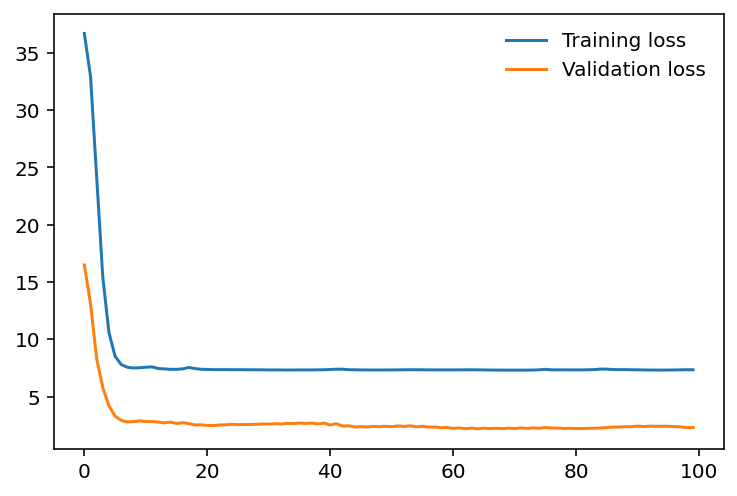

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)